# Differential abundance analysis

In [1]:
figDir = '~/Hyphosphere/data/3Exp/figures'

work_dir = '~/Hyphosphere/data/3Exp/DESeq'

# phyloseq - full object without tree (includes archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_experimental_woContam.rds'

In [344]:
library(RColorBrewer)
library(vegan)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(DESeq2)
library(VennDiagram)

In [137]:
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

In [383]:
ps = readRDS(physeq_file) 
ps
ps = ps %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    
    subset_samples(., SampleType != "GV") 
    # T0R1 has all NaN for some reason
    #subset_samples(!Sample == "T0R1") #%>%
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

ps


                                  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19433 taxa and 385 samples ]
sample_data() Sample Data:       [ 385 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 19433 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18876 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 18876 taxa by 6 taxonomic ranks ]

In [43]:
taxa = tax_table(ps) %>% as.data.frame() %>% mutate(ASV = row.names(.))
head(taxa)

Kingdom,Phylum,Class,Order,Family,Genus,ASV
Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,ASV5
Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,ASV6
Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,ASV8
Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,ASV13
Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,ASV14
Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,ASV15


In [7]:
sample_data(ps)[,'Soil'] %>% unique()

,Soil
1.1BP,Lansing
GVCLHN1-BH,Pendelton
GVFLHN1-BH,Florence
HCBS1,Sand


In [44]:
sample_data(ps)$SoilxFungus = paste(sample_data(ps)$Soil,"-",sample_data(ps)$Fungus, sep = "")
sample_data(ps) %>% head()


,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul,SoilxFungus
1.1BP,1.1BP,3,1.1,Gv,Lansing,BP,HN,1,14,1,1.067,Lansing-Gv
1.1BS,1.1BS,3,1.1,Gv,Lansing,BS,HN,1,14,1,4.421,Lansing-Gv
1.1CH,1.1CH,3,1.1,Gv,Lansing,CH,HN,1,14,1,0.325,Lansing-Gv
1.1CS,1.1CS,3,1.1,Gv,Lansing,CS,HN,1,14,1,2.116,Lansing-Gv
1.1RH,1.1RH,3,1.1,Gv,Lansing,RH,HN,1,14,1,0.174,Lansing-Gv
1.1RT,1.1RT,3,1.1,Gv,Lansing,RT,HN,1,14,1,1.561,Lansing-Gv


# Experiment 2

In [45]:
tmp = ps %>% subset_samples(Experiment == 2)

## Loop script for sample type contrasts in experiment 2
* Fertilizer treatments grouped together

In [46]:
sample_data(tmp)$SampleType %>% unique

[1] "BH" "BP" "BS" "CH" "CS" "RH" "RS"

In [47]:
library("BiocParallel")
register(MulticoreParam(20))

In [48]:
sample_data(tmp)$DAI %>% unique()

[1] 27

In [49]:
sample_data(tmp) %>% as.data.frame() %>% filter(., Fungus == "RI") %>% .$SampleType  %>% unique()

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

[1] "BH" "BS" "CH" "CS" "RH" "RS"

In [14]:
#sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
df.l2fc = NULL
Grouplist = c('Lansing-Gv', 'Florence-Gv', 'Pendelton-Gv')
ContrastList = list(c("CH","CS"), c("CH", "BS"), c("CH", "BP"), c("RH", "RS"), c("BH","BS"), c("BP", "CS"), c("BP", "BS")) 

    for (i in Grouplist) {
            print(i)
          for (j in ContrastList) { 
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='27') 
             df.l2fc = rbind(df.l2fc, r)
                     }
          }

i = "Lansing-RI"
RIContrastList = list(c("CH","CS"), c("CH", "BS"), c("RH", "RS"), c("BH","BS"))

    for (j in RIContrastList) { 
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='27') 
             df.l2fc = rbind(df.l2fc, r)
        }

df.l2fc.Exp2 = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "Lansing-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Pendelton-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [15]:
taxa %>% head() 

Kingdom,Phylum,Class,Order,Family,Genus,ASV
Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,ASV5
Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,ASV6
Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,ASV8
Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,ASV13
Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,ASV14
Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,ASV15


In [16]:
out = df.l2fc.Exp2  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 2
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp2.txt')

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
977.381944,-1.084927,0.6141637,-1.7665109,7.731017e-02,9.393601e-01,ASV5,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,2
772.320938,8.411572,1.4161221,5.9398638,2.852590e-09,3.099449e-07,ASV6,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
56.195482,8.815929,1.4665514,6.0113328,1.840042e-09,2.079248e-07,ASV8,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,2
3.676573,1.393277,3.0166225,0.4618665,6.441770e-01,9.694757e-01,ASV13,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,2
284.185280,5.948495,0.5893526,10.0932700,5.916508e-24,1.671413e-20,ASV14,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
49.214540,4.239251,2.4298523,1.7446536,8.104519e-02,9.646906e-01,ASV15,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2


In [17]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

## Get Ri CH vs Gv BPOM contrasts

In [53]:
#sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
df.l2fc = NULL

phy = subset_samples(tmp, Soil == "Lansing")
phy = subset_samples(phy, SampleType == "BP" | Fungus == "RI" & SampleType == "CH")
    numerator = "CH"
    denom<-"BP"
              
#make DESeq object
    diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
    diagdds = DESeq(diagdds, fitType="local")

r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = "Lansing-RI", Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='27') 

df.l2fc = rbind(df.l2fc, r)
        

#df.l2fc.Exp2 = df.l2fc
# #cleanup
diagdds = NULL
#df.l2fc = NULL
r = NULL

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [54]:
out = df.l2fc  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 2
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp2.txt')

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
274.702041,-0.551309056,0.4572841,-1.205616089,2.279656e-01,4.083063e-01,ASV5,Lansing-RI,SampleType,CH_BP,27,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,2
23.248492,4.002684320,1.8949944,2.112240720,3.466581e-02,1.128407e-01,ASV6,Lansing-RI,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
7.282954,0.002838641,2.4148387,0.001175499,9.990621e-01,9.994113e-01,ASV8,Lansing-RI,SampleType,CH_BP,27,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,2
6.377796,1.043387463,3.0151832,0.346044471,7.293093e-01,8.530268e-01,ASV13,Lansing-RI,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,2
94.301853,6.113858301,0.8984791,6.804675040,1.012776e-11,2.524027e-10,ASV14,Lansing-RI,SampleType,CH_BP,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
61.314695,5.402290262,2.9476484,1.832745783,6.684039e-02,1.802995e-01,ASV15,Lansing-RI,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2


In [56]:
write.table(out, file = outfile, row.names = FALSE, col.names = FALSE, sep = '\t', append = TRUE)

In [57]:
tmp = read.delim(outfile, header= TRUE, sep = '\t')
head(tmp)
tail(tmp)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
977.381944,-1.084927,0.6141637,-1.7665109,7.731017e-02,9.393601e-01,ASV5,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,2
772.320938,8.411572,1.4161221,5.9398638,2.852590e-09,3.099449e-07,ASV6,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
56.195482,8.815929,1.4665514,6.0113328,1.840042e-09,2.079248e-07,ASV8,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,2
3.676573,1.393277,3.0166225,0.4618665,6.441770e-01,9.694757e-01,ASV13,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,2
284.185280,5.948495,0.5893526,10.0932700,5.916508e-24,1.671413e-20,ASV14,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
49.214540,4.239251,2.4298523,1.7446536,8.104519e-02,9.646906e-01,ASV15,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
490771,0.0000000,NA,NA,NA,NA,NA,ASV36849,Lansing-RI,SampleType,CH_BP,27,Bacteria,Patescibacteria,Microgenomatia,Candidatus_Roizmanbacteria,NA,NA,2
490772,0.0000000,NA,NA,NA,NA,NA,ASV36865,Lansing-RI,SampleType,CH_BP,27,Bacteria,Dependentiae,Babeliae,Babeliales,NA,NA,2
490773,0.2477641,-0.9202897,3.044699,-0.3022597,0.7624541,NA,ASV36871,Lansing-RI,SampleType,CH_BP,27,Bacteria,Bacteroidetes,Bacteroidia,Sphingobacteriales,AKYH767,NA,2
490774,0.0000000,NA,NA,NA,NA,NA,ASV36896,Lansing-RI,SampleType,CH_BP,27,Bacteria,Acidobacteria,Blastocatellia_(Subgroup_4),Blastocatellales,Blastocatellaceae,JGI_0001001-H03,2
490775,0.0000000,NA,NA,NA,NA,NA,ASV37791,Lansing-RI,SampleType,CH_BP,27,Archaea,Nanoarchaeaeota,Woesearchaeia,NA,NA,NA,2
490776,0.0000000,NA,NA,NA,NA,NA,ASV38128,Lansing-RI,SampleType,CH_BP,27,Bacteria,Patescibacteria,WWE3,NA,NA,NA,2


# Experiment 1

In [50]:
tmp = ps %>% subset_samples(Experiment == 1)

In [51]:
sample_data(tmp)$DAI %>% unique

[1] 81

In [52]:
colnames(sample_data(tmp))

[1] "Sample"              "Experiment"          "Plant"              
 [4] "Fungus"              "Soil"                "SampleType"         
 [7] "Treatment"           "TimePoint"           "DAI"                
[10] "Rep"                 "Concentration_ng.ul" "SoilxFungus"

In [53]:
#sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
df.l2fc = NULL
Grouplist = c('Lansing-Gv', 'Florence-Gv', 'Pendelton-Gv')
ContrastList = list(c("CH","CS"), c("CH", "RT"), c("RT", "CS")) 

    for (i in Grouplist) {
            print(i)
          for (j in ContrastList) { 
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='81') 
             df.l2fc = rbind(df.l2fc, r)
                     }
          }



df.l2fc.Exp1 = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "Lansing-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RT_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RT_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Pendelton-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RT_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [54]:
out = df.l2fc.Exp1  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 1
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp1.txt')

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
331.72029,-2.716566,0.5217389,-5.206754,1.921730e-07,1.885675e-05,ASV5,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,1
136.95264,4.977612,1.1905977,4.180767,2.905274e-05,1.192425e-03,ASV6,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,1
0.00000,NA,NA,NA,NA,NA,ASV8,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,1
0.00000,NA,NA,NA,NA,NA,ASV13,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,1
26.70389,8.430000,1.7857267,4.720767,2.349571e-06,1.478663e-04,ASV14,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,1
0.00000,NA,NA,NA,NA,NA,ASV15,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,1


In [55]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

# Experiment 3 sample type

In [221]:
tmp = ps %>% subset_samples(Experiment == 3)
sample_data(tmp)$DAI %>% unique
sample_data(tmp)$SampleType %>% unique()
colnames(sample_data(tmp))

[1] 14 65 24 35 45 NA

[1] RH BP CS BS RT CH T0 EB GV MK
Levels: BP BS CH CS EB GV MK RH RT T0

[1] "Sample"              "Experiment"          "Plant"              
 [4] "Fungus"              "Soil"                "SampleType"         
 [7] "Treatment"           "TimePoint"           "DAI"                
[10] "Rep"                 "Concentration_ng.ul"

In [ ]:
sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
sample_data(tmp)$Rep = factor(sample_data(tmp)$Rep)
sample_data(tmp)$DAI = factor(sample_data(tmp)$DAI)
df.l2fc = NULL

Grouplist = c('Lansing-Gv')

# Date 65 does not have root hyphae samples, so run in separate loop
DateList = c(14, 24, 35, 45)
# Contrasts for first for sampling dates
ContrastList = list(c("CH","CS"), c("CH", "BS"), c("CH", "BP"), c("RH", "RT"), c("RH","CS"), c("BP", "CS"), c("BP", "BS")) 


    for (i in Grouplist) {
            print(i)
        for (k in DateList) {
                print(k)
          for (j in ContrastList) { 
              print(j)
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j & DAI == k)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local", parallel = TRUE)
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI=k) 
             df.l2fc = rbind(df.l2fc, r)
                     }
            }
          }



# Date 65 does not have root hyphae samples, so run in separate loop
DateList = 65
# Contrast list for day 65
ContrastList = list(c("CH","CS"), c("CH", "BS"), c("CH", "BP"), c("BP", "CS"), c("BP", "BS")) 

    for (i in Grouplist) {
            print(i)
        for (k in DateList) {
                print(k)
          for (j in ContrastList) { 
              print(j)
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j & DAI == k)
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local", parallel = TRUE)
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI=k) 
             df.l2fc = rbind(df.l2fc, r)
                     }
            }
          }

df.l2fc.Exp3 = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "Lansing-Gv"
[1] 14
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] 24
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] 35
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


In [ ]:
out = df.l2fc.Exp3  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 3
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp3.txt')

In [ ]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

# Experiment 3 time

In [209]:
tmp = ps %>% subset_samples(Experiment == 3)
sample_data(tmp)$DAI %>% unique
sample_data(tmp)$SampleType %>% unique()
colnames(sample_data(tmp))

[1] 14 65 24 35 45 NA

[1] RH BP CS BS RT CH T0 EB GV MK
Levels: BP BS CH CS EB GV MK RH RT T0

[1] "Sample"              "Experiment"          "Plant"              
 [4] "Fungus"              "Soil"                "SampleType"         
 [7] "Treatment"           "TimePoint"           "DAI"                
[10] "Rep"                 "Concentration_ng.ul"

In [220]:
sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
sample_data(tmp)$Rep = factor(sample_data(tmp)$Rep)
sample_data(tmp)$DAI = factor(sample_data(tmp)$DAI)
df.l2fc = NULL

Grouplist = c("BS", "CS", "RH", "CH", "BP")

# Date 65 does not have root hyphae samples, so run in separate loop
#DateList = c(14, 24, 35, 45)
# Contrasts for first for sampling dates
ContrastList = list(c("24","14"), c("35","14"), c("45","14"), c("65","14")) 


    for (i in Grouplist) {
            print(i)
          for (j in ContrastList) { 
              print(j)
    phy = subset_samples(tmp, SampleType == i & DAI %in% j )
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + DAI)
                diagdds = DESeq(diagdds, fitType="local", parallel = TRUE)
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('DAI',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = "Lansing-Gv", SampleType = i, Term='TimePoint',Contrast=paste0(numerator,'_',denom)) 
             df.l2fc = rbind(df.l2fc, r)
            }
         } 




df.l2fc.Exp3.time = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "BS"
[1] "24" "14"
[1] "24_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "35" "14"
[1] "35_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "45" "14"
[1] "45_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "65" "14"
[1] "65_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CS"
[1] "24" "14"
[1] "24_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "35" "14"
[1] "35_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "45" "14"
[1] "45_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "65" "14"
[1] "65_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "RH"
[1] "24" "14"
[1] "24_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "35" "14"
[1] "35_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "45" "14"
[1] "45_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "65" "14"
[1] "65_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "CH"
[1] "24" "14"
[1] "24_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "35" "14"
[1] "35_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "45" "14"
[1] "45_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "65" "14"
[1] "65_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "BP"
[1] "24" "14"
[1] "24_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "35" "14"
[1] "35_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "45" "14"
[1] "45_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


[1] "65" "14"
[1] "65_14"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


In [ ]:
out = df.l2fc.Exp3.time  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 3
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp3-time.txt')

In [ ]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

# Checkpoint
read back in log2foldchange files

In [58]:
readfile = file.path(work_dir, 'dfl2fc-Exp1.txt')
df.l2fc.Exp1 = read.table(readfile, header = TRUE, sep= '\t')

readfile = file.path(work_dir, 'dfl2fc-Exp2.txt')
df.l2fc.Exp2 = read.table(readfile, header = TRUE, sep= '\t')

readfile = file.path(work_dir, 'dfl2fc-Exp3.txt')
df.l2fc.Exp3 = read.table(readfile, header = TRUE, sep= '\t')

readfile = file.path(work_dir, 'dfl2fc-Exp3-time.txt')
df.l2fc.Exp3.time = read.table(readfile, header = TRUE, sep= '\t')

head(df.l2fc.Exp1)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
331.72029,-2.716566,0.5217389,-5.206754,1.921730e-07,1.885675e-05,ASV5,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,1
136.95264,4.977612,1.1905977,4.180767,2.905274e-05,1.192425e-03,ASV6,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,1
0.00000,NA,NA,NA,NA,NA,ASV8,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,1
0.00000,NA,NA,NA,NA,NA,ASV13,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,1
26.70389,8.430000,1.7857267,4.720767,2.349571e-06,1.478663e-04,ASV14,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,1
0.00000,NA,NA,NA,NA,NA,ASV15,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,1


In [59]:
df.l2fc.Exp1$Contrast %>% levels()
df.l2fc.Exp1$Subset %>% levels()

df.l2fc.Exp2$Contrast %>% levels()
df.l2fc.Exp2$Subset %>% levels()

[1] "CH_CS" "CH_RT" "RT_CS"

[1] "Florence-Gv"  "Lansing-Gv"   "Pendelton-Gv"

[1] "BH_BS" "BP_BS" "BP_CS" "CH_BP" "CH_BS" "CH_CS" "RH_RS"

[1] "Florence-Gv"  "Lansing-Gv"   "Lansing-RI"   "Pendelton-Gv"

## Identify how many ASVs are enriched in multiple soils

In [63]:
tmp = df.l2fc.Exp1 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0) %>%
    group_by(OTU) %>%
    summarize(nSig = length(padj)) %>%
    group_by(nSig) %>%
    summarize(nGroup = length(OTU))
head(tmp)
range(tmp$nSig)

nSig,nGroup
1,85
2,13
3,3


[1] 1 3

In [68]:
tmp = df.l2fc.Exp1 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0) %>%
    group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
    summarize(nSig = length(padj)) %>%
    filter(nSig > 1)
tmp

OTU,Phylum,Class,Order,Family,Genus,nSig
ASV14,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,3
ASV148,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Ideonella,2
ASV17,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Paucibacter,2
ASV18,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,3
ASV1847,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,NA,2
ASV247,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Limnohabitans,2
ASV3052,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,NA,2
ASV383,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2
ASV47,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04,2
ASV509,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2


In [65]:
tmp = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset != "Lansing-RI") %>%
    group_by(OTU) %>%
    summarize(nSig = length(padj)) %>%
    group_by(nSig) %>%
    summarize(nGroup = length(OTU))
head(tmp)
range(tmp$nSig)

nSig,nGroup
1,208
2,11
3,2


[1] 1 3

In [70]:
tmp = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset != "Lansing-RI") %>%
    group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
    summarize(nSig = length(padj)) %>%
    filter(nSig > 1)
tmp
range(tmp)

OTU,Phylum,Class,Order,Family,Genus,nSig
ASV125,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
ASV14,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,3
ASV16,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Bradyrhizobium,2
ASV1700,Proteobacteria,Deltaproteobacteria,Myxococcales,BIrii41,NA,2
ASV18,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,3
ASV190,Chloroflexi,Chloroflexia,Chloroflexales,Herpetosiphonaceae,Herpetosiphon,2
ASV23,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04,2
ASV30,Proteobacteria,Alphaproteobacteria,Rhizobiales,Rhizobiaceae,Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium,2
ASV57,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2
ASV6,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2


## Number of ASVs enriched in any soil, either experiment

In [195]:
HA.exp1 = df.l2fc.Exp1 %>%
  filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset != "Lansing-RI") %>%
    .$OTU %>%
    unique() 

HA.exp1 %>%
    length() %>%
    paste(., "ASVs enriched in hyphal samples in any soil in experiment 1")

HA.exp2 = df.l2fc.Exp2 %>%
  filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset != "Lansing-RI") %>%
    .$OTU %>%
    unique() 

HA.exp2 %>%
    length() %>%
    paste(., "ASVs enriched in hyphal samples in any soil in experiment 2")

append(HA.exp1, HA.exp2) %>% unique() %>% length() %>%
    paste(., "ASVs enriched in hyphal samples in a particular soil in at least one of the two experiments")

[1] "101 ASVs enriched in hyphal samples in any soil in experiment 1"

[1] "221 ASVs enriched in hyphal samples in any soil in experiment 2"

[1] "298 ASVs enriched in hyphal samples in a particular soil in at least one of the two experiments"

## Which ASVs are shared between Ri And Gv

[1] "236 ASVs enriched in Ri hyphal samples"

[1] "88 ASVs enriched in Gv hyphal samples"

[1] "38ASVs enriched in both Ri and Gv hyphal samples in Lansing soil"

(polygon[GRID.polygon.17650], polygon[GRID.polygon.17651], polygon[GRID.polygon.17652], polygon[GRID.polygon.17653], text[GRID.text.17654], text[GRID.text.17655], text[GRID.text.17656], text[GRID.text.17657], text[GRID.text.17658]) 

(polygon[GRID.polygon.17659], polygon[GRID.polygon.17660], polygon[GRID.polygon.17661], polygon[GRID.polygon.17662], text[GRID.text.17663], text[GRID.text.17664], text[GRID.text.17665], text[GRID.text.17666], text[GRID.text.17667]) 

png 
  2

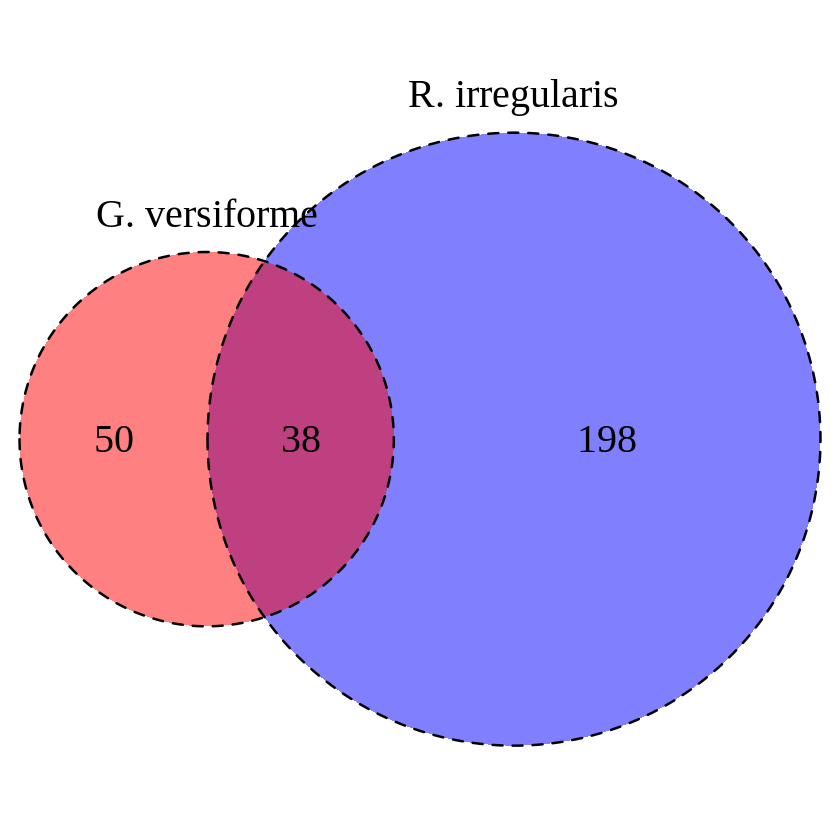

In [347]:
RIASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-RI")) %>%
    .$OTU %>%
    unique() 
    paste(length(RIASVs), "ASVs enriched in Ri hyphal samples")

GVASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv")) %>%
    .$OTU %>%
    unique() 
    paste(length(GVASVs), "ASVs enriched in Gv hyphal samples")

sharedASVs = intersect(RIASVs, GVASVs)
# tmp = df.l2fc.Exp2 %>% 
#     filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-RI", 
#                                                                                  "Lansing-Gv")) %>%
#     group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
#     summarize(nSig = length(padj)) %>%
#     filter(nSig > 1)
           
paste(length(sharedASVs), 'ASVs enriched in both Ri and Gv hyphal samples in Lansing soil', sep = '')

draw.pairwise.venn(area1 = length(RIASVs), area2 = length(GVASVs), 
cross.area = length(sharedASVs), category = c("R. irregularis", "G. versiforme"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 180, 
                   euler.d = TRUE, cat.pos = c(0,0))

outfile = file.path(figDir,'Ri_GV_Lansing_Venn.pdf')
pdf(file = outfile, width = 3, height = 3)

draw.pairwise.venn(area1 = length(RIASVs), area2 = length(GVASVs), 
cross.area = length(sharedASVs), category = c("R. irregularis", "G. versiforme"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 180, 
                   euler.d = TRUE, cat.pos = c(0,0))
dev.off()

## Which ASVs are enriched in both experiments in the same soil

In [94]:
# Get lists of experiment 1 and three lists of experiment 2, see which match
HA1.Lansing = df.l2fc.Exp1 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv")
HA2.Lansing = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv")

ConsistentLansingASVs = inner_join(HA1.Lansing, HA2.Lansing, by = "OTU")
ConsistentLansingASVs

baseMean.x,log2FoldChange.x,lfcSE.x,stat.x,pvalue.x,padj.x,OTU,Subset.x,Term.x,Contrast.x,⋯,Term.y,Contrast.y,DAI.y,Kingdom.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Experiment.y
136.95264,4.977612,1.190598,4.180767,2.905274e-05,1.192425e-03,ASV6,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
26.70389,8.430000,1.785727,4.720767,2.349571e-06,1.478663e-04,ASV14,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
159.58144,11.082384,1.362924,8.131328,4.246114e-16,2.004166e-13,ASV18,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
70.80453,8.223574,2.360521,3.483796,4.943559e-04,8.484944e-03,ASV23,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04,2
97.21443,2.890655,0.773702,3.736134,1.868708e-04,4.302586e-03,ASV47,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04,2
36.28464,4.431347,1.337195,3.313913,9.200005e-04,1.149737e-02,ASV61,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2
53.23993,9.229180,2.006168,4.600402,4.216764e-06,2.487891e-04,ASV66,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2
41.01157,7.246386,2.361361,3.068732,2.149691e-03,2.070723e-02,ASV77,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter,2
113.38638,8.225041,1.827274,4.501263,6.755095e-06,3.751064e-04,ASV509,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2
11.05237,7.191267,2.125415,3.383465,7.157740e-04,1.008493e-02,ASV708,Lansing-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2


In [95]:
# Get lists of experiment 1 and three lists of experiment 2, see which match
HA1.Florence = df.l2fc.Exp1 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Florence-Gv")
HA2.Florence = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Florence-Gv")

ConsistentFlorenceASVs  = inner_join(HA1.Florence, HA2.Florence, by = "OTU")
ConsistentFlorenceASVs

baseMean.x,log2FoldChange.x,lfcSE.x,stat.x,pvalue.x,padj.x,OTU,Subset.x,Term.x,Contrast.x,⋯,Term.y,Contrast.y,DAI.y,Kingdom.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Experiment.y
112.59177,5.606874,1.445703,3.878302,1.051880e-04,0.0045087431,ASV14,Florence-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
27.26155,7.877057,2.215345,3.555680,3.770032e-04,0.0113949114,ASV18,Florence-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
70.48888,9.215780,2.005356,4.595582,4.315422e-06,0.0003463126,ASV118,Florence-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Noviherbaspirillum,2
104.95389,8.419238,2.651464,3.175317,1.496729e-03,0.0320300102,ASV143,Florence-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2
61.26840,7.838941,2.527283,3.101727,1.923954e-03,0.0385993296,ASV341,Florence-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Azohydromonas,2
34.00978,8.514978,1.743000,4.885243,1.033013e-06,0.0001105324,ASV528,Florence-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Oligoflexales,0319-6G20,NA,2


In [96]:
# Get lists of experiment 1 and three lists of experiment 2, see which match
HA1.Pendelton = df.l2fc.Exp1 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Pendelton-Gv")
HA2.Pendelton = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Pendelton-Gv")

ConsistentPendeltonASVs = inner_join(HA1.Pendelton, HA2.Pendelton, by = "OTU")

ConsistentPendeltonASVs

baseMean.x,log2FoldChange.x,lfcSE.x,stat.x,pvalue.x,padj.x,OTU,Subset.x,Term.x,Contrast.x,⋯,Term.y,Contrast.y,DAI.y,Kingdom.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Experiment.y
72.29974,3.921081,0.8914609,4.398489,1.090074e-05,1.978903e-04,ASV6,Pendelton-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
242.22552,6.014579,0.6040114,9.957724,2.333428e-23,1.101378e-20,ASV14,Pendelton-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
232.77291,4.922357,0.5099702,9.652245,4.809100e-22,1.513263e-19,ASV18,Pendelton-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
11.52715,7.077820,2.0168512,3.509342,4.492170e-04,3.339062e-03,ASV66,Pendelton-Gv,SampleType,CH_CS,⋯,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2


In [99]:
SuperConsistentASVs = inner_join(ConsistentLansingASVs, ConsistentFlorenceASVs, by = "OTU") %>% 
        select(OTU, Phylum.x.x, Class.x.x, Order.x.x, Family.x.x, Genus.x.x) %>%
        inner_join(., ConsistentPendeltonASVs, by = "OTU") %>% 
        select(OTU, Phylum.x.x, Class.x.x, Order.x.x, Family.x.x, Genus.x.x)
SuperConsistentASVs

OTU,Phylum.x.x,Class.x.x,Order.x.x,Family.x.x,Genus.x.x
ASV14,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
ASV18,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA


# Compare consistently enriched ASVs with spore community

In [82]:
#Read in phyloseq object and subset to just GV spores
ps.spore = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    
    subset_samples(., SampleType == "GV") %>%
    filter_taxa(., function(x) max(x) > 0, TRUE)
    # T0R1 has all NaN for some reason
    #subset_samples(!Sample == "T0R1") #%>%
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(ps.spore)$Rep = as.factor(sample_data(ps.spore)$Rep)

ps.spore

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 298 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 298 taxa by 6 taxonomic ranks ]

In [101]:
#Join counts from spore sample with table of OTUs occuring in each soil
TS.spore = taxa_sums(ps.spore) %>% as.data.frame()
colnames(TS.spore) = "Counts"
TS.spore$OTU = row.names(TS.spore)
arrange(TS.spore, desc(Counts))
#sample_sums(ps.spore)

Counts,OTU
76,ASV34
61,ASV58
56,ASV109
51,ASV148
49,ASV77
45,ASV68
38,ASV381
36,ASV8
34,ASV55
33,ASV235


In [103]:
inner_join(SuperConsistentASVs, TS.spore, by = "OTU")

Warning message:
“Column `OTU` joining factor and character vector, coercing into character vector”

OTU,Phylum.x.x,Class.x.x,Order.x.x,Family.x.x,Genus.x.x,Counts
ASV18,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,12


## Review ASV found enriched in both experiments in all soils for signature of contamination
* Sandaracinaceae ASV14 and ASV18 is enriched in all soils in all experiments and is present on spores

In [111]:
physeq_file = "~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_woContam.rds"

ps = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum))
    
    # T0R1 has all NaN for some reason
    #subset_samples(!Sample == "T0R1") #%>%
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15128 taxa and 429 samples ]
sample_data() Sample Data:       [ 429 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 15128 taxa by 6 taxonomic ranks ]

In [116]:
ps %>% 
    subset_samples(SampleType == "T0") %>%
    transform_sample_counts(., function(x) x/sum(x)) %>%
   prune_taxa(c('ASV14', "ASV18"), .) %>%
   otu_table()

,ASV14,ASV18
147_T0R1,NaN,NaN
148_T0R2,0.0000000000,0.0000000000
149_T0R3,0.0003185347,0.0000000000
150_T0R4,0.0000000000,0.0001932527
153_T0R5,0.0000000000,0.0000000000
154_T0R6,0.0000000000,0.0003554081


Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

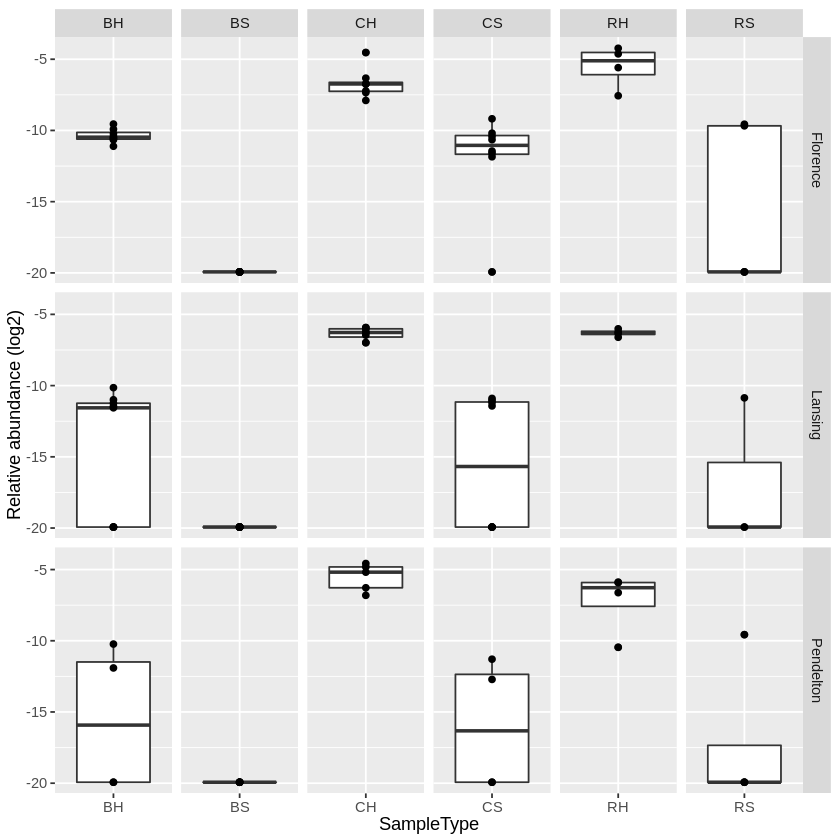

In [133]:
ps %>% 
    subset_samples(Experiment == 2 & SampleType %in% c("BS", "BH", "CH", "CS", "RH", "RS") & Fungus == "Gv") %>%
    transform_sample_counts(., function(x) x/sum(x)) %>%
   prune_taxa("ASV18",.)  %>%
    psmelt() %>%
    mutate(AbundScale = log2(Abundance + .000001)) %>% 
    ggplot(., aes(x = SampleType, y= AbundScale)) +
    geom_boxplot()+
    geom_point()+
    facet_grid(Soil~SampleType, scales = 'free_x')+
    #ggtitle(as.character(cTax))+
    ylab('Relative abundance (log2)')

* ASV18 is detected in Bulk hyphal samples that are not otherwise low biomass and prone to contamination.  In contrast it is absent from all bulk soil samples without the hyphal influence.  Suggests clear hyphal signal.  Also less abundant in the root compartment slurry samples which had the lowest DNA yields of any sampletype

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

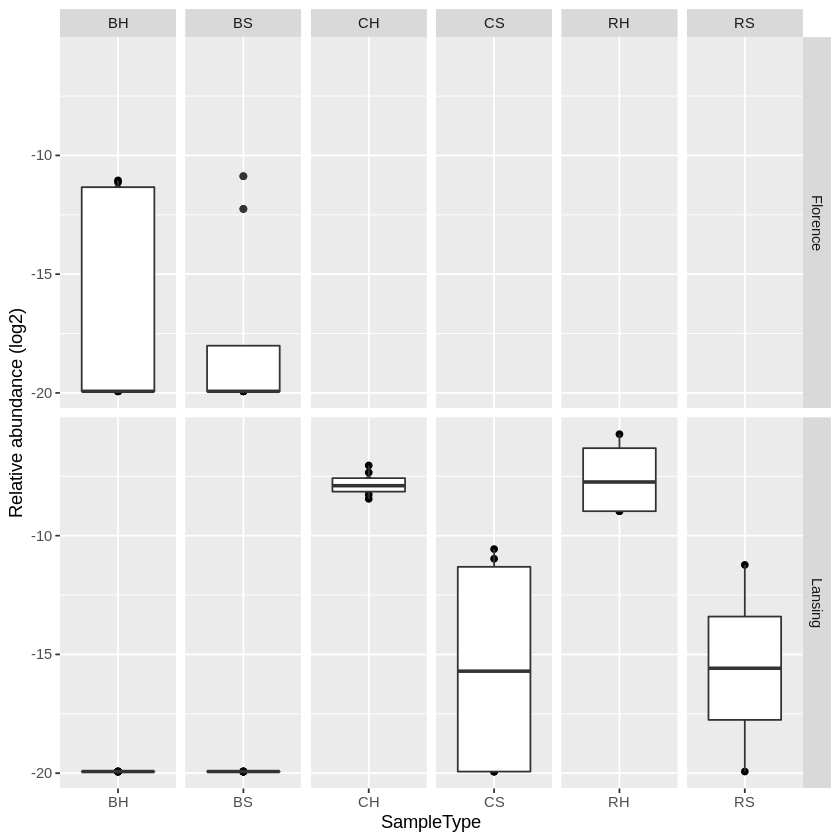

In [134]:
ps %>% 
    subset_samples(Experiment == 2 & SampleType %in% c("BS", "BH", "CH", "CS", "RH", "RS") & Fungus == "RI") %>%
    transform_sample_counts(., function(x) x/sum(x)) %>%
   prune_taxa("ASV18",.)  %>%
    psmelt() %>%
    mutate(AbundScale = log2(Abundance + .000001)) %>% 
    ggplot(., aes(x = SampleType, y= AbundScale)) +
    geom_point()+
    geom_boxplot()+
    facet_grid(Soil~SampleType, scales = 'free_x')+
    #ggtitle(as.character(cTax))+
    ylab('Relative abundance (log2)')

* Ri would not have carried ASV14 or ASV18 in on spores.  Suggesting that it may also have come from the soil or at least cross contamination in the experiment.  Root slurry is still lower than root hyphae.  RH had higher DNA yields, so this is not consistent with contamination.


# Which ASVs are time specific

In [349]:
df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
        .$OTU %>%
        unique() %>%
        length() %>%
paste(., "ASVs enriched in at least one timepoint")

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
     group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
     summarize(nSig = length(padj)) %>%
     filter(nSig > 1) %>%
     .$OTU %>%
        unique() %>%
        length() %>%
paste(.,'ASVs enriched in more than one time point')

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
     group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
     summarize(nSig = length(padj)) %>%
     filter(nSig > 2) %>%
     .$OTU %>%
        unique() %>%
        length() %>%
paste(.,'ASVs enriched in more than two time points')

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
     group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
     summarize(nSig = length(padj)) %>%
     filter(nSig > 3) %>%
     .$OTU %>%
        unique() %>%
        length() %>%
paste(.,'ASVs enriched in more than three time points')

tmp = df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
     group_by(OTU, Phylum, Class, Order, Family, Genus) %>%
     summarize(nSig = length(padj)) %>%
     filter(nSig > 4)

tmp %>%
     .$OTU %>%
        unique() %>%
        length() %>%
paste(.,'ASVs enriched in more than four time points')

tmp


[1] "105 ASVs enriched in at least one timepoint"

Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Family` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] "34 ASVs enriched in more than one time point"

Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Family` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] "15 ASVs enriched in more than two time points"

Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Family` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] "6 ASVs enriched in more than three time points"

Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Family` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] "6 ASVs enriched in more than four time points"

OTU,Phylum,Class,Order,Family,Genus,nSig
ASV14,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,5
ASV18,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,5
ASV382,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,5
ASV509,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,5
ASV66,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,5
ASV708,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,5


## How many hyphal ASVs at each time point

In [367]:
df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv" & DAI == 14) %>%
        .$OTU %>%
        unique() %>%
        length() %>%
paste(., "ASVs enriched at 14 days")

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv" & DAI == 24) %>%
        .$OTU %>%
        unique() %>%
        length() %>%
paste(., "ASVs enriched at 24 days")

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv" & DAI == 35) %>%
        .$OTU %>%
        unique() %>%
        length() %>%
paste(., "ASVs enriched at 35 days")

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv" & DAI == 45) %>%
        .$OTU %>%
        unique() %>%
        length() %>%
paste(., "ASVs enriched at 45 days")

df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv" & DAI == 65) %>%
        .$OTU %>%
        unique() %>%
        length() %>%
paste(., "ASVs enriched at 65 days")

[1] "50 ASVs enriched at 14 days"

[1] "9 ASVs enriched at 24 days"

[1] "19 ASVs enriched at 35 days"

[1] "45 ASVs enriched at 45 days"

[1] "43 ASVs enriched at 65 days"

In [ ]:
## what proportion of reads are hyphal ASVs over time

In [368]:
Exp3ASVs = df.l2fc.Exp3 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
        .$OTU %>%
        unique() %>%
        as.character()

paste(length(Exp3ASVs), " ASVs enriched in hyphal samples in Experiment 3")

[1] "105  ASVs enriched in hyphal samples in Experiment 3"

In [373]:
Exp3.HASV.m = ps %>% 
transform_sample_counts(., function(x) x/sum(x)) %>%
prune_taxa(Exp3ASVs, .) %>% 
subset_samples(SampleType == "CH" & Experiment == 3) %>%
psmelt()
                        
head(Exp3.HASV.m)

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

,OTU,Sample,Abundance,sample_Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,⋯,DAI,Rep,Concentration_ng.ul,SoilxFungus,Kingdom,Phylum,Class,Order,Family,Genus
314,ASV14,5.5CH,0.10923974,5.5CH,3,5.5,Gv,Lansing,CH,HN,⋯,65,5,0.092,Lansing-Gv,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
1175,ASV27,4.5CH,0.09394060,4.5CH,3,4.5,Gv,Lansing,CH,HN,⋯,65,4,0.121,Lansing-Gv,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhizobacter
1835,ASV45,1.3CH,0.08600997,1.3CH,3,1.3,Gv,Lansing,CH,HN,⋯,35,1,0.160,Lansing-Gv,Bacteria,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04
1188,ASV27,4.4CH,0.07644274,4.4CH,3,4.4,Gv,Lansing,CH,HN,⋯,45,4,0.145,Lansing-Gv,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhizobacter
312,ASV14,3.5CH,0.07269781,3.5CH,3,3.5,Gv,Lansing,CH,HN,⋯,65,3,0.182,Lansing-Gv,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
996,ASV23,1.4CH,0.06326602,1.4CH,3,1.4,Gv,Lansing,CH,HN,⋯,45,1,0.185,Lansing-Gv,Bacteria,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04


In [382]:
Exp3.HASV.m %>% 
    group_by(DAI, Rep) %>% 
    summarize(sAbund = sum(Abundance)) %>% 
    group_by(DAI) %>% 
    summarize(HASV_abund = mean(sAbund),
             HASV_abund.se = sd(sAbund)/sqrt(length(sAbund)))

DAI,HASV_abund,HASV_abund.se
14,0.1713662,0.02230121
24,0.1796878,0.02607415
35,0.2080608,0.02245209
45,0.3502285,0.03376835
65,0.4037610,0.03919159


# Which Hyphal ASVs change with time

In [350]:
HASVs = df.l2fc.Exp3 %>%
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
    .$OTU %>%
    unique()
length(HASVs)

df.THASVs = df.l2fc.Exp3.time %>%
    filter(SampleType == "CH" & padj < 0.05 & OTU %in% HASVs)
dim(df.THASVs)

[1] 105

[1] 60 18

In [357]:
df.THASVs %>% head()

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,SampleType,Term,Contrast,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
47.61213,-5.668830,1.572039,-3.606037,3.109089e-04,3.922634e-02,ASV292,Lansing-Gv,CH,TimePoint,35_14,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Piscinibacter,3
46.25518,-7.899768,2.126378,-3.715129,2.030997e-04,3.074930e-02,ASV487,Lansing-Gv,CH,TimePoint,35_14,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,BIrii41,NA,3
170.02341,9.970861,1.894614,5.262739,1.419246e-07,5.371847e-05,ASV494,Lansing-Gv,CH,TimePoint,35_14,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,NA,NA,3
38.28737,-6.277833,1.516239,-4.140397,3.467047e-05,8.748515e-03,ASV516,Lansing-Gv,CH,TimePoint,35_14,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA,3
40.87403,4.935372,1.271329,3.882056,1.035770e-04,1.960194e-02,ASV645,Lansing-Gv,CH,TimePoint,35_14,Bacteria,FCPU426,NA,NA,NA,NA,3
15.88647,19.257913,3.124679,6.163165,7.130497e-10,5.397786e-07,ASV2404,Lansing-Gv,CH,TimePoint,35_14,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,3


In [360]:
tmp = df.THASVs %>% select(OTU, Phylum, Class, Order, Family, Genus)
dft.CH.padj = df.THASVs %>%
    select(OTU,padj,Contrast) %>% 
    dcast(OTU ~ Contrast, value.var = "padj") 
colnames(dft.CH.padj)[-1] = c(paste(colnames(dft.CH.padj)[-1],'padj', sep = '.'))

dft.CH.l2fc = df.THASVs %>%
    select(OTU,log2FoldChange,Contrast) %>% 
    dcast(OTU ~ Contrast, value.var = "log2FoldChange") 
colnames(dft.CH.l2fc)[-1] = c(paste(colnames(dft.CH.l2fc)[-1],'l2fc', sep = '.'))

dft = full_join(dft.CH.padj, dft.CH.l2fc, by = "OTU") %>%
                select(OTU,"35_14.l2fc", "35_14.padj", "45_14.l2fc", "45_14.padj","65_14.l2fc", "65_14.padj" ) %>%
      left_join(., tmp, by = "OTU")
head(dft)

OTU,35_14.l2fc,35_14.padj,45_14.l2fc,45_14.padj,65_14.l2fc,65_14.padj,Phylum,Class,Order,Family,Genus
ASV1053,NA,NA,NA,NA,8.039158,3.789583e-04,Chloroflexi,Chloroflexia,Chloroflexales,Herpetosiphonaceae,Herpetosiphon
ASV1080,NA,NA,NA,NA,-6.319868,2.093598e-02,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Rhodanobacteraceae,Dokdonella
ASV117,NA,NA,NA,NA,-7.569677,2.776481e-02,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter
ASV1182,NA,NA,NA,NA,8.238464,1.394117e-05,Verrucomicrobia,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,Chthoniobacter
ASV14,NA,NA,NA,NA,2.793061,2.242494e-06,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
ASV141,NA,NA,NA,NA,-4.762268,2.361775e-02,Proteobacteria,Deltaproteobacteria,Myxococcales,BIrii41,NA


### write file of logfold change for HASVs over time

In [362]:
outfile = file.path(figDir, 'HASVs_l2fcTime.txt')
write.table(dft, file = outfile, sep = '\t', row.names = FALSE)

# Which hyphal ASVs are associated with POM

### Gv

In [88]:
HASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv", "Florence-Gv", "Pendelton-Gv")) %>%
    .$OTU %>%
    unique() 
paste(length(HASVs), 'enriched in hyphal samples compared to core slurry in at least one of three soils')

#Currently cannot check Ri as BPOM was not collected in those mesocosms.  
#Could run Deseq model against Gv BPOM in lansing soil since it was from the bulk compartment anyway

BPASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "BP_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv", "Florence-Gv", "Pendelton-Gv")) %>%
    .$OTU %>%
    unique() 
paste(length(BPASVs), 'enriched in BP samples compared to CS in at least one of three soils')

NonSpecificASVs = intersect(HASVs, BPASVs) 
NonSpecificASVs %>% length() %>% paste(., "Gv ASVs also enriched BPOM samples compared to CS")



tmp = df.l2fc.Exp2 %>%
    filter(Contrast == "CH_BP" & OTU %in% GvASVs) %>%
    filter(OTU %in% BPASVs)

dim(tmp)

tmp %>% 
    group_by(Order) %>%
    summarise(count = length(Order))

tmp
    

[1] "221 enriched in hyphal samples compared to core slurry in at least one of three soils"

[1] "299 enriched in BP samples compared to CS in at least one of three soils"

[1] "34 Gv ASVs also enriched BPOM samples compared to CS"

[1] 136  18

Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”

Order,count
Betaproteobacteriales,4
Caulobacterales,4
Cellvibrionales,4
Chitinophagales,4
Chloroflexales,16
Cytophagales,8
Dongiales,4
DS-100,4
Gammaproteobacteria_Incertae_Sedis,12
Kallotenuales,8


baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
838.64079,7.88252377,1.4695606,5.36386436,8.146009e-08,2.406467e-06,ASV6,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
382.13555,0.22022826,0.3644401,0.60429205,5.456495e-01,8.337388e-01,ASV16,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Bradyrhizobium,2
135.05437,0.23808990,0.3945606,0.60343044,5.462224e-01,8.337388e-01,ASV21,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Devosiaceae,Devosia,2
190.11398,-1.39975805,0.3392310,-4.12626782,3.686979e-05,7.161830e-04,ASV77,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter,2
138.17217,-1.33904046,0.5843124,-2.29165148,2.192576e-02,1.274210e-01,ASV117,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter,2
110.14044,-1.51523106,0.5903402,-2.56670823,1.026690e-02,7.509256e-02,ASV280,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter,2
0.00000,NA,NA,NA,NA,NA,ASV312,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Chloroflexi,Chloroflexia,Kallotenuales,NA,NA,2
43.86152,-0.28559821,0.5672797,-0.50345215,6.146464e-01,8.848412e-01,ASV386,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Rhodanobacteraceae,NA,2
25.97212,0.07795061,0.6662388,0.11700100,9.068593e-01,9.838765e-01,ASV390,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Hyphomonadaceae,SWB02,2
46.57080,-0.41326358,0.6113672,-0.67596624,4.990621e-01,7.845566e-01,ASV416,Lansing-Gv,SampleType,CH_BP,27,Bacteria,Proteobacteria,Alphaproteobacteria,Dongiales,Dongiaceae,Dongia,2


In [68]:
library(VennDiagram)

Warning message:
“package ‘VennDiagram’ was built under R version 3.6.3”Loading required package: grid
Loading required package: futile.logger
Warning message:
“package ‘futile.logger’ was built under R version 3.6.3”

(polygon[GRID.polygon.236], polygon[GRID.polygon.237], polygon[GRID.polygon.238], polygon[GRID.polygon.239], text[GRID.text.240], text[GRID.text.241], text[GRID.text.242], text[GRID.text.243], text[GRID.text.244]) 

(polygon[GRID.polygon.245], polygon[GRID.polygon.246], polygon[GRID.polygon.247], polygon[GRID.polygon.248], text[GRID.text.249], text[GRID.text.250], text[GRID.text.251], text[GRID.text.252], text[GRID.text.253]) 

png 
  2

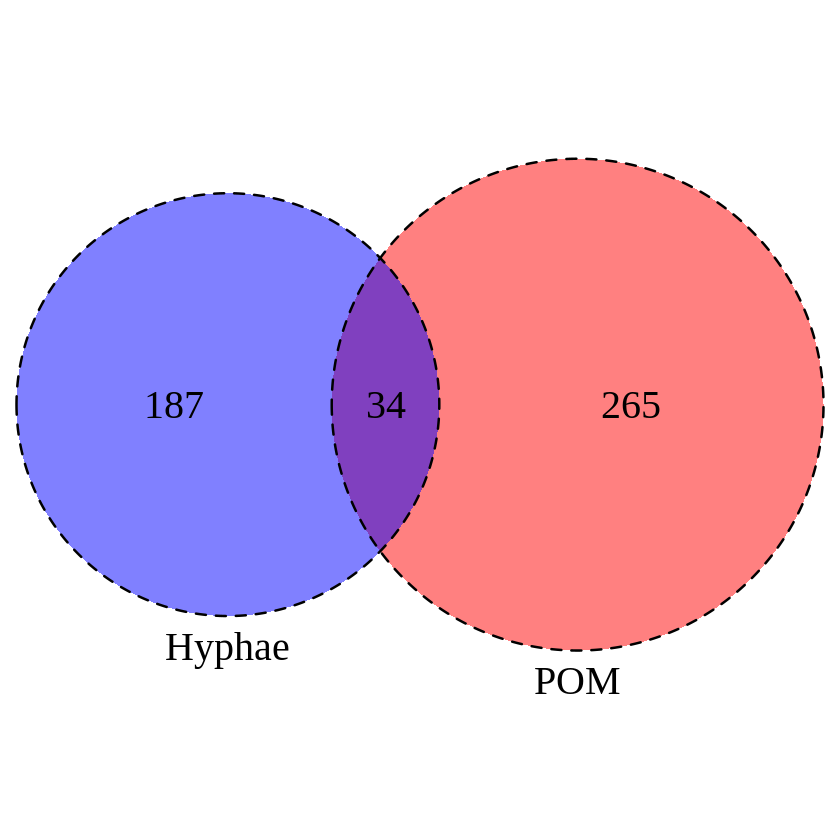

In [96]:
#area 1 = hybrid
#area 2 = Fert
#area 3 = Enzyme
draw.pairwise.venn(area1 = 221, area2 = 299, 
cross.area = 34, category = c("Hyphae", "POM"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 180, 
                   euler.d = TRUE, cat.pos = c(0,0))

outfile = file.path(figDir,'CH-BP_Venn_Gv.pdf')
pdf(file = outfile, width = 3, height = 3)

draw.pairwise.venn(area1 = 221, area2 = 299, 
cross.area = 34, category = c("Hyphae", "POM"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 180, 
                   euler.d = TRUE, cat.pos = c(0,0))
dev.off()


### Ri

In [91]:
HASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-RI")) %>%
    .$OTU %>%
    unique() 
paste(length(HASVs), 'enriched in Ri hyphal samples compared to core slurry in Lansing soils')

#Currently cannot check Ri as BPOM was not collected in those mesocosms.  
#Could run Deseq model against Gv BPOM in lansing soil since it was from the bulk compartment anyway

BPASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "BP_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv")) %>%
    .$OTU %>%
    unique() 
paste(length(BPASVs), 'enriched in BP samples compared to CS in Lansing soils')

NonSpecificASVs = intersect(HASVs, BPASVs) 
NonSpecificASVs %>% length() %>% paste(., "Ri ASVs also enriched BPOM samples compared to CS")

[1] "236 enriched in Ri hyphal samples compared to core slurry in Lansing soils"

[1] "191 enriched in BP samples compared to CS in Lansing soils"

[1] "35 Ri ASVs also enriched BPOM samples compared to CS"

(polygon[GRID.polygon.218], polygon[GRID.polygon.219], polygon[GRID.polygon.220], polygon[GRID.polygon.221], text[GRID.text.222], text[GRID.text.223], text[GRID.text.224], text[GRID.text.225], text[GRID.text.226]) 

(polygon[GRID.polygon.227], polygon[GRID.polygon.228], polygon[GRID.polygon.229], polygon[GRID.polygon.230], text[GRID.text.231], text[GRID.text.232], text[GRID.text.233], text[GRID.text.234], text[GRID.text.235]) 

png 
  2

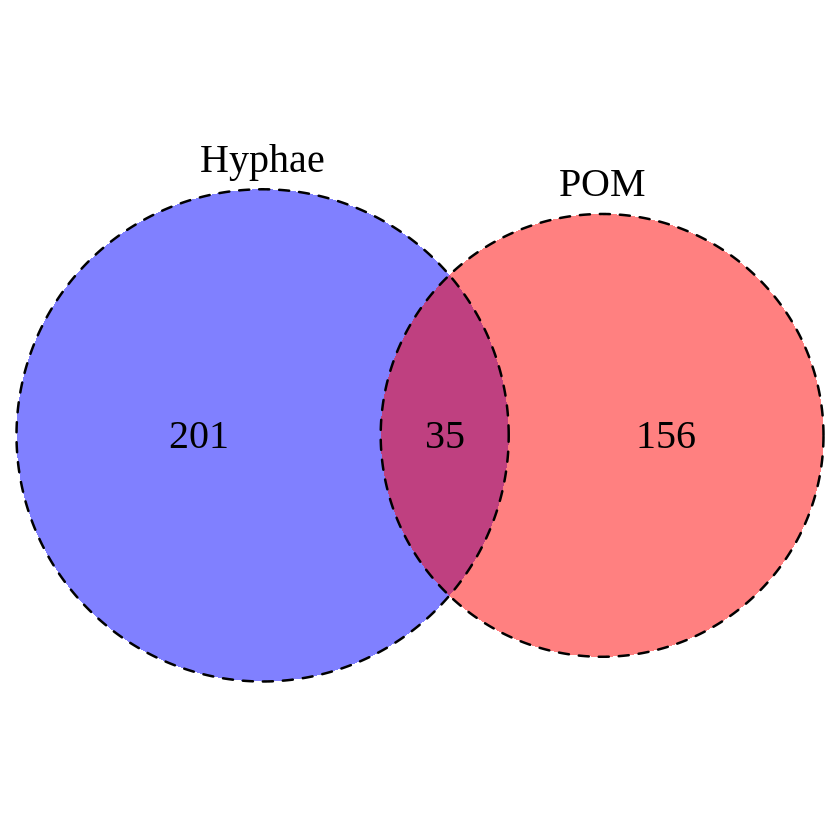

In [95]:
draw.pairwise.venn(area1 = 236, area2 = 191, 
cross.area = 35, category = c("Hyphae", "POM"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 0, 
                   euler.d = TRUE, cat.pos = c(0,0))

outfile = file.path(figDir,'CH-BP_Venn_Ri.pdf')
pdf(file = outfile, width = 3, height = 3)

draw.pairwise.venn(area1 = 236, area2 = 191, 
cross.area = 35, category = c("Hyphae", "POM"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 0, 
                   euler.d = TRUE, cat.pos = c(0,0))
dev.off()


## Overlap between enriched ASVs in hyphal compartment and root compartment

### Gv

[1] "221 enriched in hyphal samples compared to core slurry in at least one of three soils"

[1] "41 enriched in root hyphal samples compared to root sand slurry in at least one of three soils"

[1] "18 Gv ASVs also enriched in root hyphal samples compared to root sand slurry"

(polygon[GRID.polygon.301], polygon[GRID.polygon.302], polygon[GRID.polygon.303], polygon[GRID.polygon.304], text[GRID.text.305], text[GRID.text.306], text[GRID.text.307], text[GRID.text.308], text[GRID.text.309]) 

OTU,Phylum,Class,Order,Family,Genus
ASV6,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio
ASV13,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas
ASV14,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
ASV17,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Paucibacter
ASV18,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
ASV19,Planctomycetes,Planctomycetacia,Pirellulales,Pirellulaceae,Pirellula
ASV23,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae,possible_genus_04
ASV30,Proteobacteria,Alphaproteobacteria,Rhizobiales,Rhizobiaceae,Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium
ASV32,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia
ASV44,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Hydrogenophaga


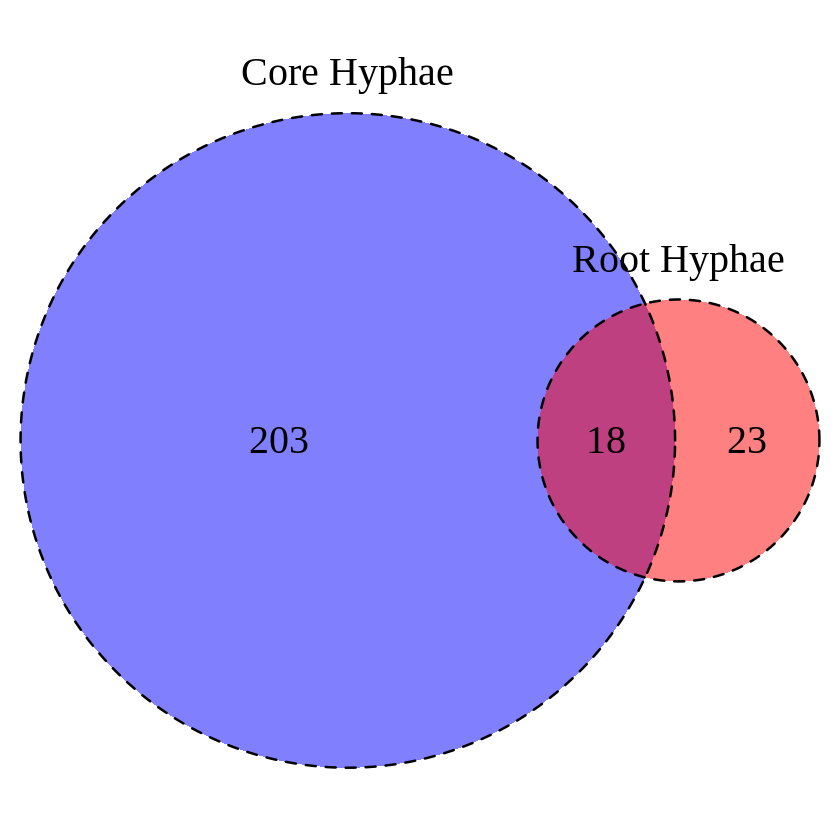

In [104]:
HASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv", "Florence-Gv", "Pendelton-Gv")) %>%
    .$OTU %>%
    unique() 
paste(length(HASVs), 'enriched in hyphal samples compared to core slurry in at least one of three soils')

#Currently cannot check Ri as BPOM was not collected in those mesocosms.  
#Could run Deseq model against Gv BPOM in lansing soil since it was from the bulk compartment anyway

RHASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "RH_RS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv", "Florence-Gv", "Pendelton-Gv")) %>%
    .$OTU %>%
    unique() 
paste(length(RHASVs), 'enriched in root hyphal samples compared to root sand slurry in at least one of three soils')

SharedASVs = intersect(HASVs, RHASVs) 
SharedASVs %>% length() %>% paste(., "Gv ASVs also enriched in root hyphal samples compared to root sand slurry")


draw.pairwise.venn(area1 = length(HASVs), area2 = length(RHASVs), 
cross.area = length(SharedASVs), category = c("Core Hyphae", "Root Hyphae"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 0, 
                   euler.d = TRUE, cat.pos = c(0,0))


df.l2fc.Exp2 %>%
    filter(OTU %in% RHASVs) %>%
        select(OTU, Phylum, Class, Order, Family, Genus) %>%
        unique()
#outfile = file.path(figDir,'CH-BP_Venn_Ri.pdf')
# pdf(file = outfile, width = 3, height = 3)

# draw.pairwise.venn(area1 = 236, area2 = 191, 
# cross.area = 35, category = c("Hyphae", "POM"), lty = rep(2, 2), 
#                  fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 0, 
#                    euler.d = TRUE, cat.pos = c(0,0))
# dev.off()

### Ri

[1] "236 enriched in RI hyphal samples from Lansing"

[1] "19 enriched in root hyphal samples compared to root sand slurry from Lansing"

[1] "10 ASVs enriched in hyphal samples of both root and soil compartments"

(polygon[GRID.polygon.272], polygon[GRID.polygon.273], polygon[GRID.polygon.274], polygon[GRID.polygon.275], text[GRID.text.276], text[GRID.text.277], lines[GRID.lines.278], text[GRID.text.279], lines[GRID.lines.280], text[GRID.text.281], text[GRID.text.282]) 

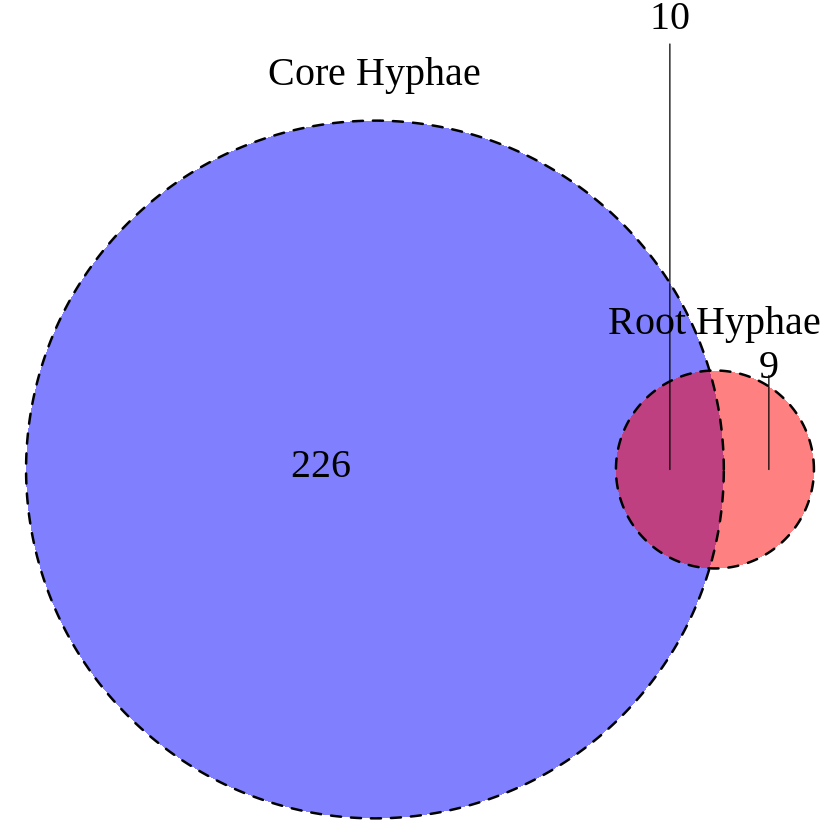

In [101]:
HASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-RI")) %>%
    .$OTU %>%
    unique() 
paste(length(HASVs), 'enriched in RI hyphal samples from Lansing')

#Currently cannot check Ri as BPOM was not collected in those mesocosms.  
#Could run Deseq model against Gv BPOM in lansing soil since it was from the bulk compartment anyway

RHASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "RH_RS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-RI")) %>%
    .$OTU %>%
    unique() 
paste(length(RHASVs), 'enriched in root hyphal samples compared to root sand slurry from Lansing')

SharedASVs = intersect(HASVs, RHASVs) 
SharedASVs %>% length() %>% paste(., "ASVs enriched in hyphal samples of both root and soil compartments")


draw.pairwise.venn(area1 = length(HASVs), area2 = length(RHASVs), 
cross.area = length(SharedASVs), category = c("Core Hyphae", "Root Hyphae"), lty = rep(2, 2), 
                 fill = c("blue",  "red"), cex = 2, cat.cex = 2, scaled = TRUE, rotation.degree = 0, 
                   euler.d = TRUE, cat.pos = c(0,0))

# Check hyphal ASVs can be detected in targeted hypothesis test

In [7]:
RiASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-RI")) %>%
    .$OTU %>%
    unique() 
length(RiASVs)

GvASVs = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% c("Lansing-Gv")) %>%
    .$OTU %>%
    unique() 
length(GvASVs)

[1] 236

[1] 88

In [38]:
df.l2fc.Exp2 %>% 
    filter(Contrast == "BH_BS" & OTU %in% RiASVs & Subset %in% c("Lansing-RI")) %>%
    arrange(pvalue)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
7.628263,5.9105101,2.9798749,1.9834760,0.04731429,0.9999796,ASV1310,Lansing-RI,SampleType,BH_BS,27,Bacteria,Acidobacteria,Subgroup_17,NA,NA,NA,2
18.160871,4.5918979,2.4107625,1.9047492,0.05681268,0.9999796,ASV27,Lansing-RI,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhizobacter,2
21.693302,1.2182342,0.7167407,1.6996862,0.08918996,0.9999796,ASV932,Lansing-RI,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,SC-I-84,NA,2
18.128149,3.1964250,1.9988917,1.5990986,0.10979869,0.9999796,ASV226,Lansing-RI,SampleType,BH_BS,27,Bacteria,Verrucomicrobia,Verrucomicrobiae,Opitutales,Opitutaceae,Lacunisphaera,2
10.763075,4.3859396,2.9463489,1.4886016,0.13659232,0.9999796,ASV1328,Lansing-RI,SampleType,BH_BS,27,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Ellin6055,2
11.091348,4.3120003,2.9685489,1.4525617,0.14634550,0.9999796,ASV95,Lansing-RI,SampleType,BH_BS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Haliangiaceae,Haliangium,2
4.109663,3.3113137,2.2965980,1.4418343,0.14934913,0.9999796,ASV1096,Lansing-RI,SampleType,BH_BS,27,Bacteria,Proteobacteria,Alphaproteobacteria,Dongiales,Dongiaceae,Dongia,2
13.519920,3.2738890,2.3098686,1.4173486,0.15638104,0.9999796,ASV653,Lansing-RI,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Nitrosomonadaceae,Ellin6067,2
2.147603,4.1405048,2.9935658,1.3831347,0.16662356,0.9999796,ASV672,Lansing-RI,SampleType,BH_BS,27,Bacteria,Verrucomicrobia,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,Chthoniobacter,2
1.861340,-3.7840421,2.9938277,-1.2639479,0.20624874,0.9999796,ASV880,Lansing-RI,SampleType,BH_BS,27,Bacteria,Bacteroidetes,Bacteroidia,Cytophagales,Microscillaceae,Chryseolinea,2


In [12]:
df.l2fc.Exp2 %>% 
    filter(Contrast == "BH_BS" & OTU %in% GvASVs & Subset %in% c("Lansing-Gv")) %>%
    arrange(pvalue)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
16.4344448,7.40593026,1.3789456,5.3707198,7.842298e-08,1.987462e-05,ASV190,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Herpetosiphonaceae,Herpetosiphon,2
17.5089858,7.02216431,1.7032496,4.1228041,3.742879e-05,8.299835e-03,ASV280,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter,2
10.8116142,6.71372805,1.8144472,3.7001507,2.154715e-04,3.185386e-02,ASV57,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2
6.2732592,6.02819515,1.7998997,3.3491840,8.104996e-04,1.027019e-01,ASV14,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
7.4625380,6.23820815,2.6060755,2.3937174,1.667859e-02,8.218841e-01,ASV18,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
26.9054896,-4.47981535,2.0802505,-2.1534981,3.127956e-02,9.998327e-01,ASV117,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_Incertae_Sedis,Unknown_Family,Acidibacter,2
4.4617006,4.87182239,2.3403150,2.0816951,3.737033e-02,9.998327e-01,ASV672,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Verrucomicrobia,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,Chthoniobacter,2
18.1594992,3.80684891,2.0259364,1.8790564,6.023679e-02,9.998327e-01,ASV27,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhizobacter,2
3.4659046,-4.46410156,2.9626698,-1.5067834,1.318662e-01,NA,ASV1523,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Acidobacteria,Thermoanaerobaculia,Thermoanaerobaculales,Thermoanaerobaculaceae,Subgroup_10,2
8.5982146,3.17967018,2.9861127,1.0648192,2.869578e-01,9.998327e-01,ASV251,Lansing-Gv,SampleType,BH_BS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2


# Check against abundance of MREs in BH samples

### Get MRE table from original phyloseq object

In [223]:
ps.MRE = readRDS("~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_experimental_woContam.rds") %>%
        subset_samples(Fungus == "Gv" & Experiment == 2) %>%
        
         transform_sample_counts(., function(x) x/sum(x)) %>% 
         prune_taxa(c("ASV2", "ASV4", "ASV11"),.)

tax_table(ps.MRE)
        

,Kingdom,Phylum,Class,Order,Family,Genus
ASV2,Bacteria,NA,NA,NA,NA,NA
ASV4,Bacteria,NA,NA,NA,NA,NA
ASV11,Bacteria,NA,NA,NA,NA,NA


Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

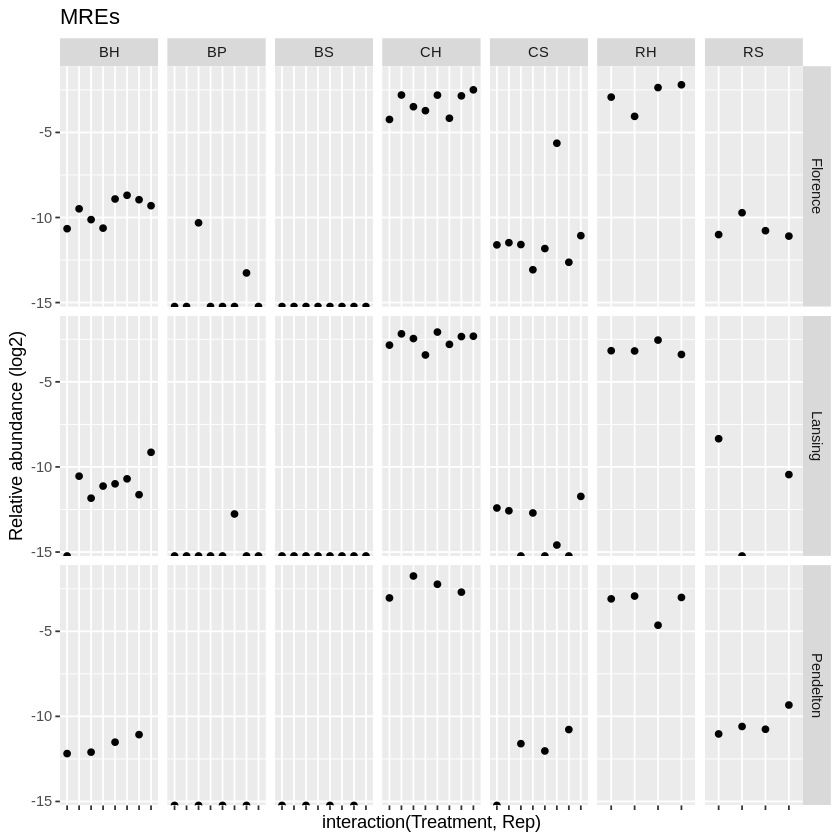

In [224]:
ps.MRE %>% 
    psmelt() %>% 
    #filter(Soil %in% c("Lansing", "Pendelton", "Florence") & Fungus == "Gv")  %>%                                     
    group_by(sample_Sample, Soil, SampleType, Treatment, Rep) %>%
    summarise(sAbund = sum(Abundance)) %>%
    ggplot(., aes(x=interaction(Treatment,Rep), y= log2(sAbund))) +
    geom_point()+
    facet_grid(Soil~SampleType, scales = 'free_x')+
    ggtitle(as.character("MREs"))+
    theme(axis.text.x = element_blank())+
    ylab('Relative abundance (log2)')


In [225]:
MREtab = ps.MRE %>% 
    psmelt() %>% 
    filter(Soil != "Sand", Experiment == 2, SampleType %in% c("BS","BH") & Fungus == "Gv") %>%
    group_by(sample_Sample, Soil) %>%
    summarise(sAbund = sum(Abundance))

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

### Get groups - Myxococcales, Fibrobacteres, Burkholderiaceae, Chloroflexaceae, Oli

In [283]:
TopHASVOrderList = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% 
           c("Lansing-Gv", "Florence-Gv", "Pendelton-Gv")) %>%
    group_by(Order) %>% 
    summarize(sL2FC = sum(log2FoldChange), n = length(Order)) %>%
    arrange(desc(sL2FC)) %>%
    filter(!is.na(Order))%>%
    .$Order %>%  
   as.character()
TopHASVOrderList[1:10]

Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] "Myxococcales"          "Betaproteobacteriales" "Fibrobacterales"      
 [4] "Chloroflexales"        "Rhizobiales"           "Cytophagales"         
 [7] "Caulobacterales"       "SBR1031"               "Flavobacteriales"     
[10] "Chthoniobacterales"

## Get taxa relative abundance from phyloseq object without MREs

In [226]:
ps.rel = ps %>% 
transform_sample_counts(., function(x) x/sum(x)) 



In [325]:
TaxList = df.l2fc.Exp2 %>% 
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset %in% 
           c("Lansing-Gv", "Florence-Gv", "Pendelton-Gv") & Order %in% TopHASVOrderList[1:5]) %>%
    .$OTU %>%
    as.character()%>%
    unique() 
 

Taxtab = ps.rel %>% 
    prune_taxa(TaxList, .) %>%
    subset_samples(Experiment == 2 & SampleType %in% c("BS","BH") & Fungus == "Gv") %>%
      psmelt() %>% 
     group_by(sample_Sample, Soil, SampleType, Order) %>%
    summarise(sAbund = sum(Abundance))
 head(Taxtab)

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

sample_Sample,Soil,SampleType,Order,sAbund
GVCLHN1-BH,Pendelton,BH,Betaproteobacteriales,0.0000000000
GVCLHN1-BH,Pendelton,BH,Chloroflexales,0.0017359963
GVCLHN1-BH,Pendelton,BH,Fibrobacterales,0.0002314662
GVCLHN1-BH,Pendelton,BH,Myxococcales,0.0002810661
GVCLHN1-BH,Pendelton,BH,Rhizobiales,0.0117551749
GVCLHN1-BS,Pendelton,BS,Betaproteobacteriales,0.0000000000


In [326]:
cs = brewer.pal(3,"Set2")
df = full_join(MREtab,Taxtab, by = "sample_Sample") 
head(df)

sample_Sample,Soil.x,sAbund.x,Soil.y,SampleType,Order,sAbund.y
GVCLHN1-BH,Pendelton,0.0002145994,Pendelton,BH,Betaproteobacteriales,0.0000000000
GVCLHN1-BH,Pendelton,0.0002145994,Pendelton,BH,Chloroflexales,0.0017359963
GVCLHN1-BH,Pendelton,0.0002145994,Pendelton,BH,Fibrobacterales,0.0002314662
GVCLHN1-BH,Pendelton,0.0002145994,Pendelton,BH,Myxococcales,0.0002810661
GVCLHN1-BH,Pendelton,0.0002145994,Pendelton,BH,Rhizobiales,0.0117551749
GVCLHN1-BS,Pendelton,0.0000000000,Pendelton,BS,Betaproteobacteriales,0.0000000000


In [327]:
df = full_join(MREtab,Taxtab, by = "sample_Sample")
#tmp = df %>% filter(SampleType == "BH")

Warning message:
“Duplicated aesthetics after name standardisation: shape”

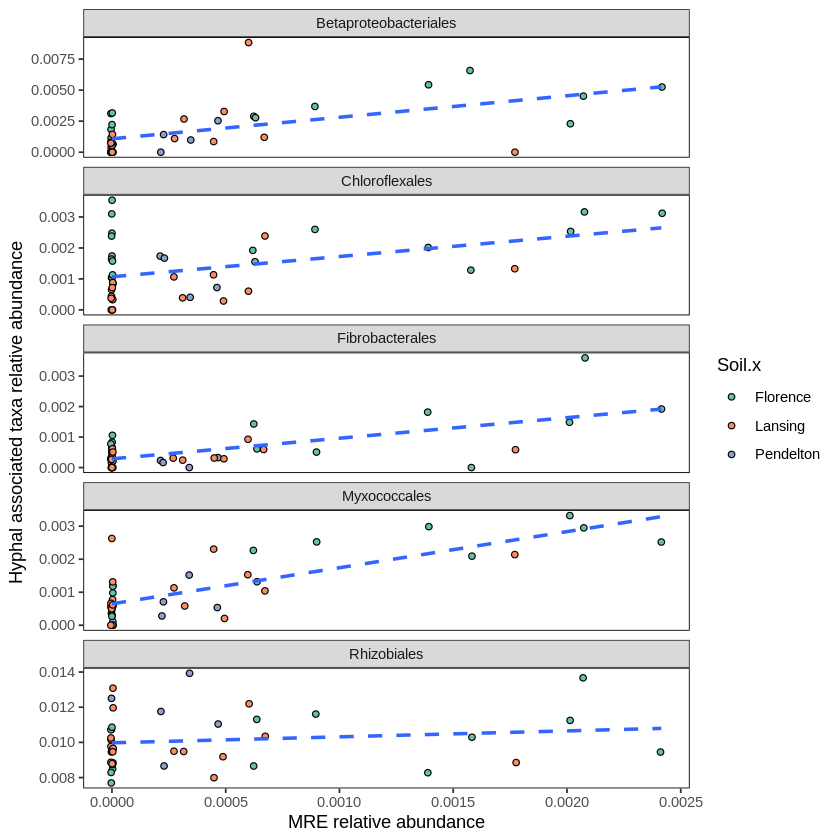

In [329]:
p1 = df %>%
    #filter(OTU %in% c("ASV14", "ASV18")) %>%
    ggplot(.,aes(x = sAbund.x, y = sAbund.y)) +
        geom_jitter(aes(fill = Soil.x), shape = 21, pch = 2) +
        theme_pub()+
        #scale_x_continuous(trans='log2')+
        #scale_y_continuous(trans='log2')+
        scale_fill_manual(values = cs) +#, labels = c("Bulk hyphosphere", "Bulk soil"))+
        ylab("Hyphal associated taxa relative abundance") +
        xlab("MRE relative abundance")+
       #annotate(geom="text", x=0.0005, y=.0020, label=EqLabel,
       #      color="black")+
        geom_smooth(aes(x = sAbund.x, y = sAbund.y), method='lm', se = FALSE,  lty = 2)+
       facet_wrap(~Order, scales = "free_y", ncol = 1)
p1

In [332]:
tmp = df %>% filter(Order == "Betaproteobacteriales")
m1 = lm(sAbund.y~Soil.x + SampleType + sAbund.x, data = tmp)
anova(m1)
summary(m1)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Soil.x,2,3.378791e-05,1.689396e-05,6.8388011,0.0031112162
SampleType,1,4.131791e-05,4.131791e-05,16.7258020,0.0002406376
sAbund.x,1,1.989734e-06,1.989734e-06,0.8054594,0.3755983913
Residuals,35,8.646084e-05,2.470310e-06,NA,NA



Call:
lm(formula = sAbund.y ~ Soil.x + SampleType + sAbund.x, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0028569 -0.0009130 -0.0002459  0.0005743  0.0065731 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0033555  0.0008074   4.156 0.000198 ***
Soil.xLansing   -0.0014020  0.0006094  -2.301 0.027492 *  
Soil.xPendelton -0.0019269  0.0007537  -2.556 0.015071 *  
SampleTypeBS    -0.0015882  0.0007017  -2.263 0.029914 *  
sAbund.x         0.5096067  0.5678234   0.897 0.375598    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001572 on 35 degrees of freedom
Multiple R-squared:  0.4714,	Adjusted R-squared:  0.411 
F-statistic: 7.802 on 4 and 35 DF,  p-value: 0.0001322


In [333]:
tmp = df %>% filter(Order == "Myxococcales")
m2 = lm(sAbund.y~Soil.x + SampleType + sAbund.x, data = tmp)
anova(m2)
summary(m2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Soil.x,2,6.888453e-06,3.444226e-06,9.756817,4.288948e-04
SampleType,1,1.157191e-05,1.157191e-05,32.780938,1.776559e-06
sAbund.x,1,4.857225e-06,4.857225e-06,13.759566,7.171122e-04
Residuals,35,1.235525e-05,3.530072e-07,NA,NA



Call:
lm(formula = sAbund.y ~ Soil.x + SampleType + sAbund.x, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.186e-03 -3.443e-04 -4.085e-05  2.559e-04  2.009e-03 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0011703  0.0003052   3.834 0.000503 ***
Soil.xLansing   -0.0001702  0.0002304  -0.739 0.465071    
Soil.xPendelton -0.0006648  0.0002849  -2.333 0.025515 *  
SampleTypeBS    -0.0003812  0.0002652  -1.437 0.159512    
sAbund.x         0.7962174  0.2146492   3.709 0.000717 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005941 on 35 degrees of freedom
Multiple R-squared:  0.6537,	Adjusted R-squared:  0.6141 
F-statistic: 16.51 on 4 and 35 DF,  p-value: 1.087e-07


In [334]:
tmp = df %>% filter(Order == "Fibrobacterales")
m3 = lm(sAbund.y~Soil.x + SampleType + sAbund.x, data = tmp)
anova(m3)
summary(m3)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Soil.x,2,5.544934e-06,2.772467e-06,12.018798,0.000106277
SampleType,1,1.643891e-06,1.643891e-06,7.126358,0.011438853
sAbund.x,1,2.964732e-06,2.964732e-06,12.852277,0.001017312
Residuals,35,8.073714e-06,2.306776e-07,NA,NA



Call:
lm(formula = sAbund.y ~ Soil.x + SampleType + sAbund.x, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.496e-03 -2.020e-04 -2.093e-05  1.278e-04  1.789e-03 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)      0.0005143  0.0002467   2.085  0.04447 * 
Soil.xLansing   -0.0004494  0.0001862  -2.413  0.02118 * 
Soil.xPendelton -0.0004673  0.0002303  -2.029  0.05013 . 
SampleTypeBS     0.0001371  0.0002144   0.640  0.52662   
sAbund.x         0.6220571  0.1735163   3.585  0.00102 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0004803 on 35 degrees of freedom
Multiple R-squared:  0.5571,	Adjusted R-squared:  0.5064 
F-statistic:    11 on 4 and 35 DF,  p-value: 6.958e-06


In [335]:
tmp = df %>% filter(Order == "Chloroflexales")
m4 = lm(sAbund.y~Soil.x + SampleType + sAbund.x, data = tmp)
anova(m4)
summary(m4)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Soil.x,2,1.933308e-05,9.666542e-06,21.565231,7.885585e-07
SampleType,1,1.379653e-06,1.379653e-06,3.077889,8.811609e-02
sAbund.x,1,5.359110e-07,5.359110e-07,1.195572,2.816773e-01
Residuals,35,1.568863e-05,4.482466e-07,NA,NA



Call:
lm(formula = sAbund.y ~ Soil.x + SampleType + sAbund.x, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.205e-03 -4.308e-04 -8.313e-05  3.553e-04  1.611e-03 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0020704  0.0003439   6.020 7.28e-07 ***
Soil.xLansing   -0.0013924  0.0002596  -5.364 5.33e-06 ***
Soil.xPendelton -0.0010214  0.0003211  -3.181  0.00307 ** 
SampleTypeBS    -0.0001408  0.0002989  -0.471  0.64062    
sAbund.x         0.2644746  0.2418778   1.093  0.28168    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0006695 on 35 degrees of freedom
Multiple R-squared:  0.5753,	Adjusted R-squared:  0.5267 
F-statistic: 11.85 on 4 and 35 DF,  p-value: 3.437e-06


In [336]:
tmp = df %>% filter(Order == "Rhizobiales")
m5 = lm(sAbund.y~Soil.x + SampleType + sAbund.x, data = tmp)
anova(m5)
summary(m5)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Soil.x,2,6.973739e-06,3.486869e-06,1.4725600,0.2431991
SampleType,1,4.808975e-06,4.808975e-06,2.0309062,0.1629858
sAbund.x,1,9.445439e-07,9.445439e-07,0.3988958,0.5317638
Residuals,35,8.287637e-05,2.367896e-06,NA,NA



Call:
lm(formula = sAbund.y ~ Soil.x + SampleType + sAbund.x, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0025102 -0.0009503 -0.0000957  0.0008873  0.0033941 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0097906  0.0007905  12.385 2.38e-14 ***
Soil.xLansing    0.0002848  0.0005967   0.477   0.6361    
Soil.xPendelton  0.0012990  0.0007379   1.760   0.0871 .  
SampleTypeBS    -0.0003872  0.0006870  -0.564   0.5766    
sAbund.x         0.3511144  0.5559285   0.632   0.5318    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001539 on 35 degrees of freedom
Multiple R-squared:  0.1331,	Adjusted R-squared:  0.03405 
F-statistic: 1.344 on 4 and 35 DF,  p-value: 0.2733


In [343]:
anova(m1) %>% as.data.frame()  %>% 
    bind_rows(., as.data.frame(anova(m2))) 
    #rbind(.,cbind(,,,,,))

Df,Sum Sq,Mean Sq,F value,Pr(>F)
2,3.378791e-05,1.689396e-05,6.8388011,3.111216e-03
1,4.131791e-05,4.131791e-05,16.7258020,2.406376e-04
1,1.989734e-06,1.989734e-06,0.8054594,3.755984e-01
35,8.646084e-05,2.470310e-06,NA,NA
2,6.888453e-06,3.444226e-06,9.7568175,4.288948e-04
1,1.157191e-05,1.157191e-05,32.7809381,1.776559e-06
1,4.857225e-06,4.857225e-06,13.7595659,7.171122e-04
35,1.235525e-05,3.530072e-07,NA,NA


In [385]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /data/home/be68/anaconda3/envs/MyR/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] VennDiagram_1.6.20          futile.logger_1.4.3        
 [3] DESeq2_1.22.1               SummarizedExperiment_1.12.0
 [5] DelayedArray_0.8.0          BiocParallel_1.16.6        
 [7] matrixStats_0.54.0          Biobase_2.44.0             
 [9] GenomicRanges_1.34.0        GenomeInfoDb_1.18.1        
[11] IRanges_2.18.2              S4Vectors_0.22.0           
[13] BiocGenerics_0.30.0         ggplot2_3.2.1              
[15] gridExtra_2.3               phyloseq_1.28.0            
[17] reshape2_1.4.3              dplyr_0.8.0.1              
[19] tidyr_0.8.3                 vegan_2.5-5               

In [388]:
citation()


To cite R in publications use:

  R Core Team (2019). R: A language and environment for statistical
  computing. R Foundation for Statistical Computing, Vienna, Austria.
  URL https://www.R-project.org/.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {R: A Language and Environment for Statistical Computing},
    author = {{R Core Team}},
    organization = {R Foundation for Statistical Computing},
    address = {Vienna, Austria},
    year = {2019},
    url = {https://www.R-project.org/},
  }

We have invested a lot of time and effort in creating R, please cite it
when using it for data analysis. See also ‘citation("pkgname")’ for
citing R packages.
